<a href="https://colab.research.google.com/github/umamah333/LargeLanguageModel/blob/main/21088746_UMAMAH_USMAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spam Email Detection using BERT for Sequence Classification:**
Dataset Used:
* https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv*




# **Loading Libraries**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import matplotlib.pyplot as plt
from google.colab import drive
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import seaborn as sns
import plotly.express as px

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Pre-Processing Steps**
Data Pre-processing and Exploring the Dataset for better understanding

In [ ]:
####loading dataset then performing EDA, statistical analysis
#performing one hot encoding aswell using lambda function


def load_data(dataset_path):
    """Load the dataset, perform preprocessing, and visualize EDA."""
    df = pd.read_csv(dataset_path, encoding='latin1')

    # Rename columns
    df.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)

    # Perform preprocessing
    df['spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)
    df = df[['Message', 'spam']]

    # Visualize class distribution
    plt.figure(figsize=(6, 4))
    df['spam'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])  # Replace 'Category' with 'spam'
    plt.title('Class Distribution')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

    # Visualize message length distribution
    df['Message_Length'] = df['Message'].apply(len)
    plt.figure(figsize=(6, 4))
    plt.hist(df[df['spam'] == 1]['Message_Length'], bins=50, color='orange', label='Spam', alpha=0.7)
    plt.hist(df[df['spam'] == 0]['Message_Length'], bins=50, color='skyblue', label='Ham', alpha=0.7)
    plt.title('Message Length Distribution')
    plt.xlabel('Message Length')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Statistical analysis
    plt.figure(figsize=(10, 6))

    # Boxplot of message length
    sns.boxplot(x='spam', y='Message_Length', data=df)  # Replace 'Category' with 'spam'
    plt.title('Boxplot of Message Length')
    plt.xlabel('Category')
    plt.ylabel('Message Length')
    plt.show()

    # Generate word clouds for spam and ham messages
    spam_words = ' '.join(df[df['spam'] == 1]['Message'])  # Replace 'Category' with 'spam'
    ham_words = ' '.join(df[df['spam'] == 0]['Message'])  # Replace 'Category' with 'spam'

    plt.figure(figsize=(15, 8))

    # Word cloud for spam messages
    plt.subplot(1, 2, 1)
    wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.title('Word Cloud for Spam Messages')
    plt.axis('off')
    plt.show()

    # Word cloud for ham messages
    plt.subplot(1, 2, 2)
    wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
    plt.imshow(wordcloud_ham, interpolation='bilinear')
    plt.title('Word Cloud for Ham Messages')
    plt.axis('off')
    plt.show()

    # Barplot of average message length
    avg_length_spam = df[df['spam'] == 1]['Message_Length'].mean()
    avg_length_ham = df[df['spam'] == 0]['Message_Length'].mean()

    plt.figure(figsize=(6, 4))
    plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['orange', 'skyblue'])
    plt.title('Average Message Length')
    plt.xlabel('Category')
    plt.ylabel('Average Length')
    plt.show()

    return df

In [ ]:
def balance_dataset(df):
    """Balance the dataset using downsampling."""
    df_spam = df[df['spam'] == 1]
    df_ham = df[df['spam'] == 0]

    # Sample an equal number of instances from the majority class
    df_ham_downsampled = df_ham.sample(df_spam.shape[0])

    # Concatenate the balanced datasets
    df_balanced = pd.concat([df_ham_downsampled, df_spam])

    # Visualize class distribution
    plt.figure(figsize=(6, 4))
    df_balanced['spam'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
    plt.title('Balanced Class Distribution')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

    return df_balanced


# **Tokenization:**

The tokenize_data function is a utility designed to prepare raw text data for deep learning models, particularly for tasks like text classification or sequence labeling. Given a collection of text samples, represented either as a single string or a list of strings, along with a tokenizer object, the function performs tokenization, padding, and truncation as necessary to create tokenized sequences suitable for model input. By leveraging the provided tokenizer, the function breaks down each text sample into individual tokens, ensuring that the sequences adhere to a maximum length specified by the max_length parameter. Padding is applied to ensure uniform sequence lengths, while truncation occurs when text samples exceed the maximum allowed length. The function returns the tokenized sequences in a format ready for consumption by the deep learning model, facilitating seamless integration of text data into the model training or inference pipeline

In [ ]:
def tokenize_data(texts, tokenizer, max_length=128):
    """Tokenize the text data.
    It  processes raw text data for deep learning models.
    It tokenizes, pads, and potentially truncates the input text sequences to ensure uniformity and adherence to a maximum sequence length.
     The output is formatted for direct use in model training or inference."""

    return tokenizer(texts, padding=True, truncation=True, max_length=max_length)

In [ ]:
def prepare_datasets(train_df, test_df, tokenizer):
    """Prepare train and test datasets."""
    train_encodings = tokenize_data(train_df['Message'].tolist(), tokenizer)
    test_encodings = tokenize_data(test_df['Message'].tolist(), tokenizer)

    train_dataset = EmailDataset(train_encodings, train_df['spam'].tolist())
    test_dataset = EmailDataset(test_encodings, test_df['spam'].tolist())

    return train_dataset, test_dataset

The provided code defines a custom dataset class named **EmailDataset** tailored for use with PyTorch's data handling utilities. This class encapsulates tokenized representations of text data along with their corresponding labels, typically used for tasks like **spam detection**. The class initializes by storing the tokenized encodings and labels passed to it. It includes methods to retrieve individual data samples by index, where it constructs a dictionary containing the encoded text data as PyTorch tensors alongside their respective labels. Additionally, the class provides a method to determine the total number of samples in the dataset. Overall, the EmailDataset class streamlines the process of integrating tokenized text data with their associated labels, facilitating seamless incorporation into PyTorch's training pipelines via data loaders.

In [ ]:
class EmailDataset(torch.utils.data.Dataset):
    """Custom dataset class."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# **Model Training Function**

In [ ]:
def train(model, train_loader, optimizer, device, num_epochs=3):
    """Training loop."""
    model.to(device)
    train_losses = []
    accuracies = []
    learning_rates = []
    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_accuracies = []
        epoch_learning_rates = []
        model.train()
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            epoch_losses.append(loss.item())

            # Calculate accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            accuracy = torch.sum(predictions == labels).item() / len(labels)
            accuracies.append(accuracy)
            epoch_accuracies.append(accuracy)

            # Get learning rate
            learning_rate = optimizer.param_groups[0]['lr']
            learning_rates.append(learning_rate)
            epoch_learning_rates.append(learning_rate)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Training Loss: {sum(epoch_losses)/len(epoch_losses)}")
        print(f"  Accuracy: {sum(epoch_accuracies)/len(epoch_accuracies)}")
        print(f"  Learning Rate: {sum(epoch_learning_rates)/len(epoch_learning_rates)}")

        # Plot training loss, accuracy, and learning rate
        plt.figure(figsize=(15, 5))

        # Plot training loss
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 3, 2)
        plt.plot(accuracies, label='Accuracy', color='green')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()

        # Plot learning rate
        plt.subplot(1, 3, 3)
        plt.plot(learning_rates, label='Learning Rate', color='red')
        plt.xlabel('Batch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate')
        plt.legend()

        # Show plot
        plt.tight_layout()
        plt.show()

        # Clear the previous output cell
        clear_output(wait=True)

# **Model Evaluation Function**
This function will evaluate the model performance on test set adnd then will produce a confusion matrix for better understanding

In [ ]:
def evaluate(model, test_loader, device):
    """Evaluate on the test set and compute the confusion matrix."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, cm

# **Model Deploy Function:**
this function will deploy the model ,will get the custom message from the user and to end the message user will type** EXIT** , it will then send the message in the form of tokens to the trained model and will generate output as **HAM** or **SPAM** email

In [ ]:
def deploy_model(model, tokenizer, device, num_emails=3):
    """Deploy the trained model with visualization."""
    email_count = 0
    while email_count < num_emails:
        message = input("Enter the message to classify (type 'exit' to stop): ")
        if message.lower() == 'exit':
            break

        # Tokenize the input message
        encoded_message = tokenizer(message, padding=True, truncation=True, max_length=128, return_tensors='pt')
        input_ids = encoded_message['input_ids'].to(device)
        attention_mask = encoded_message['attention_mask'].to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).item()

        # Display the prediction
        if predictions == 1:
            print("Predicted: SPAM")
        else:
            print("Predicted: HAM")



        email_count += 1

# **Main Function Executions:**

These all functions will be executed and then called seeprately so every graph and visualisation can be stored and viewed for analysis of the model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

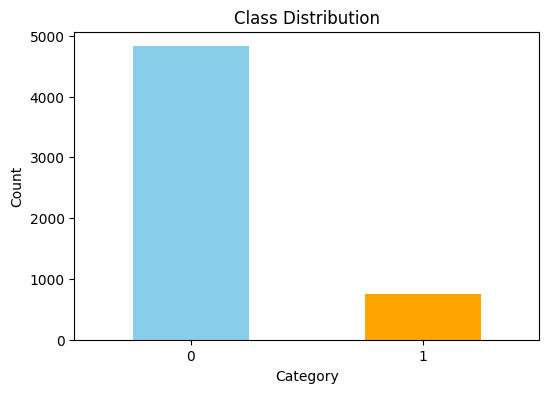

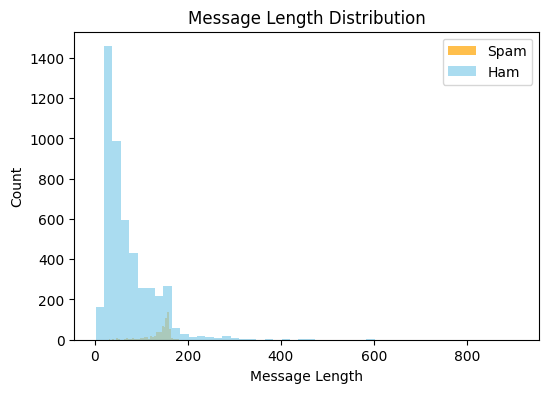

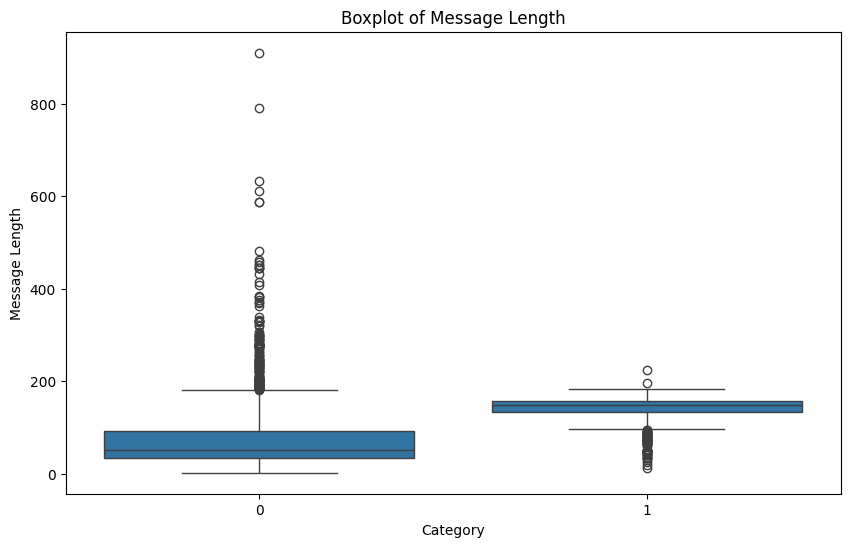

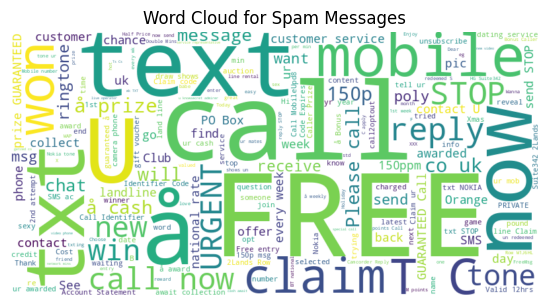

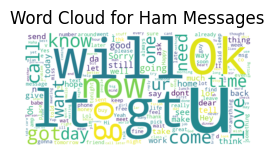

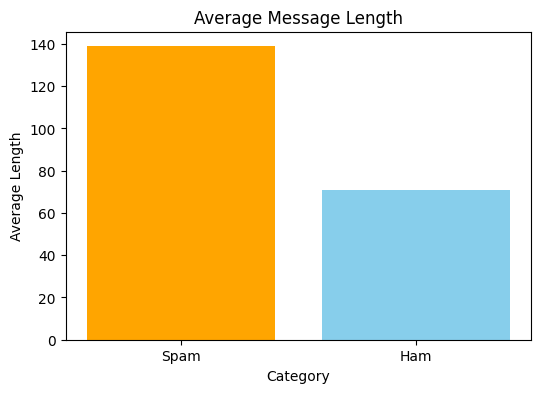

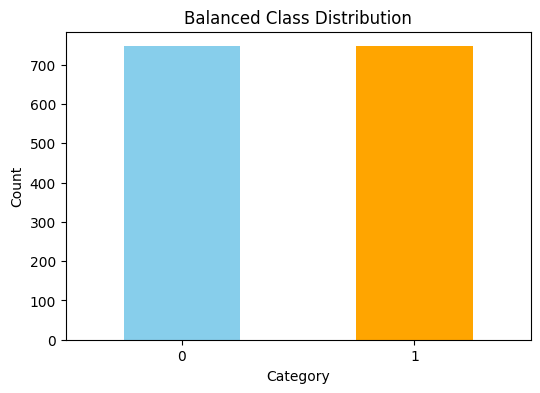

In [ ]:
def main_load_preprocess():
    ''' defined sepeprately so every EDA graph can be tracked '''
    # Load and preprocess data
    dataset_path = '/content/drive/MyDrive/spam.csv'
    df = load_data(dataset_path)
    df_balanced = balance_dataset(df)
    # Split the dataset
    train_df, test_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['spam'], random_state=42)

    # Load BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Prepare datasets
    train_dataset, test_dataset = prepare_datasets(train_df, test_df, tokenizer)

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    return train_dataset, test_dataset, tokenizer, train_loader, test_loader

# Define model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)

# Load and preprocess data, and prepare data loaders
train_dataset, test_dataset, tokenizer, train_loader, test_loader = main_load_preprocess()

In [ ]:
# Define model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def main_train(train_dataset, test_dataset, tokenizer):
    # Define model
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Define optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Train the model
    train(model, train_loader, optimizer, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    return model

def main_evaluate(model, test_loader, device):
    """Evaluate the model and print evaluation metrics."""
    accuracy, cm = evaluate(model, test_loader, device)
    print(f'Test Accuracy: {accuracy}')
    print('Confusion Matrix:')
    print(cm)

def main_deploy(model, tokenizer, device, num_emails=3):
    # Deploy the model
    deploy_model(model, tokenizer, device, num_emails=3)

Epoch 3/3:
  Training Loss: 0.030205596706364305
  Accuracy: 0.9908333333333333
  Learning Rate: 5.000000000000004e-05


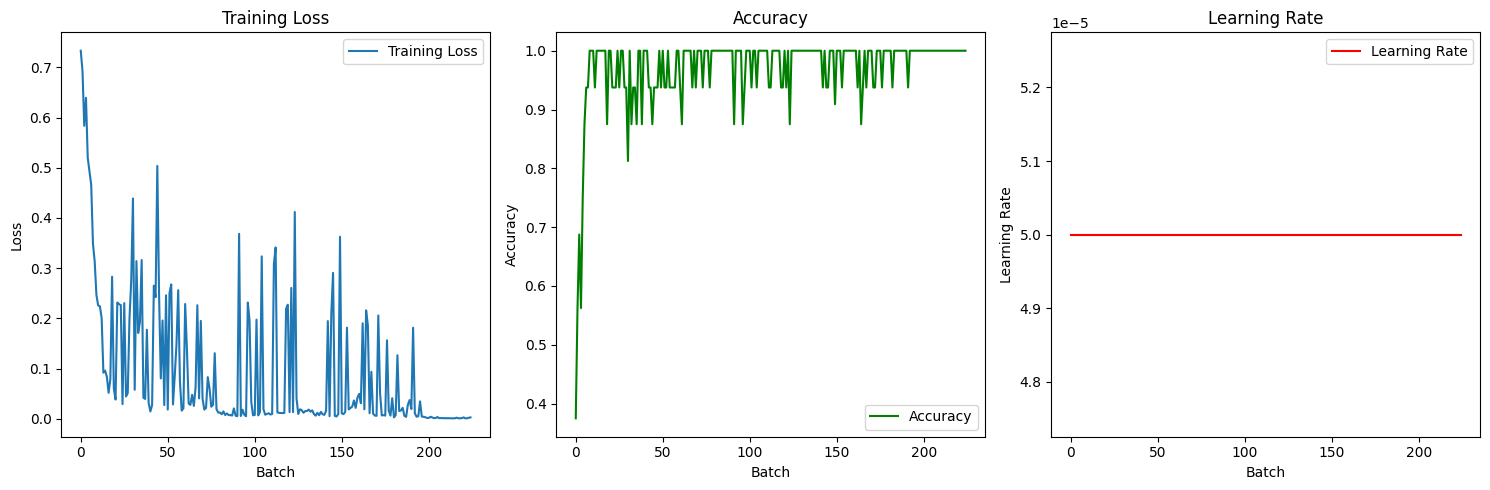

In [ ]:

trained_model = main_train(train_dataset, test_dataset, tokenizer)

In [ ]:
main_evaluate(trained_model, test_loader, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Test Accuracy: 0.9732441471571907
Confusion Matrix:
[[149   1]
 [  7 142]]


In [ ]:
#this will plot confusion matrix for evaluted dataset performance when called
def plot_confusion_matrix(cm):
    """Plot the confusion matrix."""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlOrRd', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Given confusion matrix
cm = [[149, 1],
      [7, 142]]

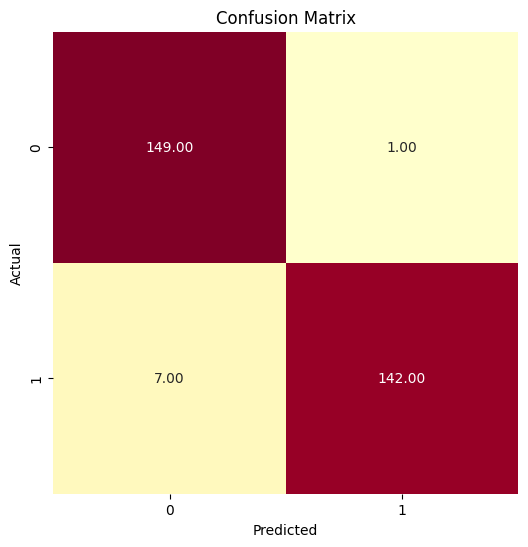

In [ ]:

# Plot confusion matrix
plot_confusion_matrix(cm)

In [ ]:
main_deploy(trained_model, tokenizer, torch.device('cuda' if torch.cuda.is_available() else 'cpu'), num_emails=3)

Enter the message to classify (type 'exit' to stop): Dear students,     As promised, I have added some example student assignments (reports and code) from previous semesters. LLM - Example Assignments     These were graded in the range 68-74%, so they are not perfect and you should aim to do better and fulfil all of the Rubric requirements. For example, some of these do not show enough relevant plots or figures to illustrate the usage of the model.     It goes without saying, that you need to do your own original work, and these reports and code would be flagged in TurnItIn submissions.     Cheers,  Will
Predicted: HAM
Enter the message to classify (type 'exit' to stop):  Don't forget the Big Spring Savings Event, ends TODAY!	View Online | Add to Contacts    	MATALAN	   	 	 Womens Mens Girls Boys Homeware New In  	  SALE - 50% OFf**    	 	 Hey Abdul, as a Matalan Me Member, we're excited to give you EXCLUSIVE Early Access to our BIG sale! Shop up to 50% off across Women's, Men's, Kids'